In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import sys
from platypus import NSGAII, Problem, Real, nondominated, Integer
import matplotlib.pyplot as plt
from platypus.problems import DTLZ2
import scipy

sys.path.append(os.path.abspath("../class_dir"))
from circuit_class import Circuit
from standingwave_class import Standingwave
# from standingwave_class import Standingwave
from circuit_class import get_test_name

In [2]:
def delete_simfiles(path):
        os.remove(f'{cir_path}_{test_name}.cir')
        os.remove(f'{cir_path}_{test_name}.raw')
        os.remove(f'{cir_path}_{test_name}.op.raw')
        os.remove(f'{cir_path}_{test_name}.log')

# 並列共振回路ver.

シミュレーションを回しなおさなくていい場合、**<span style="color: green; "> 緑太字で示した部分</span>**をコメントアウトする

## コイルの設計→Lに当たりつけてシミュレーション

シミュレーションをするコイルのインダクタンス値を用意する

In [3]:
L_str = '$L(\mu H)$'
r_str = '$R_L(\mu \Omega)$'
C_str = '$C(\mu F)$'
R_str = '$R(\Omega)$'
coil_list = pd.read_csv('../coil_design/coil_list.csv').sort_values(L_str)
coil_list

,Unnamed: 0,w,s,n,$L(\mu H)$,$R_L(\mu \Omega)$,$C(\mu F)$
6568,6568,4.9,3.4,1.0,0.042649,3.449563,14.847971
6533,6533,4.8,3.6,1.0,0.042706,3.480000,14.828440
6567,6567,4.9,3.3,1.0,0.042907,3.530729,14.758879
6532,6532,4.8,3.5,1.0,0.042961,3.562857,14.740209
6495,6495,4.7,3.7,1.0,0.043023,3.596353,14.719179
...,...,...,...,...,...,...,...
65,65,0.1,0.1,66.0,66.195166,69.600000,0.009567
61,61,0.1,0.1,62.0,66.197686,101.417143,0.009566
64,64,0.1,0.1,65.0,66.270858,77.554286,0.009556
62,62,0.1,0.1,63.0,66.272524,93.462857,0.009555


## コイルのインダクタンスLと直列負荷抵抗Rを変数としたシミュレーション

### <span style="color: red; ">変数指定</span>
テストするL, Rの範囲と間隔を指定(単位はLはμH, RはΩ)

In [4]:
# Rは単位Ω, 範囲指定はlogスケールで行う
R_start = -1
R_end = 3
R_num = 37

# 結合係数Kは0.1で固定
K=0.1

# t_cutは5msシミュレーションなので0.0049
t_cut_time = 0.0049

# テスト元にするcirファイルのパス
cir_path = '/Users/yuki/Documents/LTspice/test/parallel_0930/main_parallel'

変数のリストを用意

In [5]:
# 浮動少数点数型の変数の配列
L_values_num = list(coil_list[L_str])[::20]
L_num = len(L_values_num)
C_values_num = list(coil_list[C_str])[::20]
C_num = len(C_values_num)
R_values_num = list(np.logspace(R_start, R_end, R_num))

# 文字列型の変数の配列
L_values = list(map(lambda x: str(x)+"u", L_values_num))
C_values = list(map(lambda x: str(x)+"u", C_values_num))
R_values = list(map(lambda x: str(x), R_values_num))

収集するデータのDataFrame用のカラムを準備

In [6]:
columns = [L_str,'L_str', R_str, 'R_str', C_str, 'C_str', 'V(out)', 'W']

## <span style="color: red; ">条件増やしたり変えたらここも変更チェック
条件を表す文字列を作成

In [9]:
condition = 'parallel_0930'
condition += f'_L:{round(L_values_num[0], 3)}~{round(L_values_num[-1], 3)}(n={L_num})_R:{R_values[0]}~{R_values[-1]}(n={R_num})_K:{K}'
condition

'parallel_0930_L:0.043~65.895(n=329)_R:0.1~1000.0(n=37)_K:0.1'

結果保存用の条件別のフォルダを作成

In [10]:
result_dir = f'../result/{condition}'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

## 全パターンのシミュレーションの実行&CSVに保存

### <span style="color: green; ">完了している場合はコメントアウトしておく

In [26]:
# sim_df = pd.DataFrame(columns= columns)
# change_elements = {}
# change_elements['K'] = K

# for i in tqdm(range(L_num)):
#     change_elements['L'] = L_values[i]
#     change_elements['C'] = C_values[i]
#     for r in tqdm(range(R_num)):
#         change_elements['R'] = R_values[r]
#         parallel = Standingwave(cir_path)
#         test_name = get_test_name(change_elements)
#         parallel.change_element_run(change_elements)
#         parallel.change_element_df_save(change_elements)
# #         parallel.t_cut(t_cut_time)
#         v = parallel.get_amp_means()["V(test)"][test_name]
#         W_mean = parallel.get_W('I(R1)', 'V(a)', change_elements=change_elements, t_cut_time=t_cut_time)['W'].mean()
#         sim_df = sim_df.append({
#             L_str: L_values_num[i], 
#             'L_str': L_values[i], 
#             R_str: R_values_num[r],
#             'R_str': R_values[r], 
#             C_str: C_values_num[i], 
#             'C_str': C_values[i], 
#             'V(out)': v, 
#             'W': W_mean
#         }, ignore_index=True)
#         delete_simfiles(f'{cir_path}_{test_name}')
#         del parallel
#         gc.collect()
# sim_df.to_csv(f'{result_dir}/LRC_VW.csv')

## csvからデータを読みこみ

In [12]:
csv_df = pd.read_csv(f'{result_dir}/LRC_VW.csv', dtype = {'L_str':'object', 'R_str':'object',  'C_str':'object'})
csv_df

,Unnamed: 0,$L(\mu H)$,L_str,$R(\Omega)$,R_str,$C(\mu F)$,C_str,V(out),W
0,0,0.042649,0.0426494232775542u,0.100000,0.1,14.847971,14.84797094777797u,2.398797,3.903056
1,1,0.042649,0.0426494232775542u,0.129155,0.1291549665014884,14.847971,14.84797094777797u,1.603435,4.370126
2,2,0.042649,0.0426494232775542u,0.166810,0.16681005372000587,14.847971,14.84797094777797u,2.987027,4.878799
3,3,0.042649,0.0426494232775542u,0.215443,0.21544346900318834,14.847971,14.84797094777797u,2.944247,5.251678
4,4,0.042649,0.0426494232775542u,0.278256,0.2782559402207124,14.847971,14.84797094777797u,1.591558,5.333342
...,...,...,...,...,...,...,...,...,...
12168,12168,65.895054,65.8950538142599u,359.381366,359.38136638046257,0.009610,0.0096100900008305u,5.190379,0.024831
12169,12169,65.895054,65.8950538142599u,464.158883,464.15888336127773,0.009610,0.0096100900008305u,4.880576,0.020851
12170,12170,65.895054,65.8950538142599u,599.484250,599.4842503189409,0.009610,0.0096100900008305u,2.927036,0.015199
12171,12171,65.895054,65.8950538142599u,774.263683,774.263682681127,0.009610,0.0096100900008305u,1.469795,0.011948


# 出力側電圧

## L別にRと出力側電圧振幅の関係をみる

波形確認

In [27]:
# change_elements = {}
# change_elements['K'] = K

# # count = 0

# for L in tqdm(L_values[50:60]):
#     parallel = Standingwave(cir_path)
#     change_elements['L'] = L
#     for R in R_values:
#         change_elements['R'] = R
#         parallel.change_element_df_save(change_elements)
#     parallel.t_cut(0.0049)
# #     if count>55:
#     parallel.dfs["V(test)"][f'K=0.1L={L}R=1000.0'].plot(x="t", y="V(test)", title = f'L={L}H')
#     del parallel
#     gc.collect()

描画(x, yどちらも対数軸)して保存

In [30]:
ncols=3
nrows = 1+len(L_values)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
plt_count = 0
for L in L_values[::10]:
    csv_df[csv_df['L_str']==L].plot(x=R_str, y="V(out)", title = f'L={L}uH', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
    plt_count+=1
plt.savefig(f'{result_dir}/R_amp.png')
plt.close('all')

## R別にLと出力側電圧振幅の関係をみる

描画(x, yどちらも対数軸)して保存

In [15]:
ncols=3
nrows = 1+len(R_values)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
plt_count = 0
for R in R_values:
    csv_df[csv_df['R_str']==R].plot(x=L_str, y="V(out)", title = f'R={R}Ω', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
    plt_count+=1
plt.savefig(f'{result_dir}/L_amp.png')
plt.close('all')

## 出力電圧が最高だったテストパターン

In [16]:
max_v = csv_df[csv_df['V(out)']==csv_df['V(out)'].max()]
max_v

,Unnamed: 0,$L(\mu H)$,L_str,$R(\Omega)$,R_str,$C(\mu F)$,C_str,V(out),W
11289,11289,4.489743,4.489743245629728u,0.278256,0.2782559402207124,0.141045,0.1410453478338694u,120.3267,2.274041


# 入力側消費電力

## L別でRと整定後の平均消費電力の関係をみる

波形確認

In [17]:
# change_elements = {}
# change_elements['K'] = K

# ncols=3
# nrows = 1+20//ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
# plt_count = 0

# for L in tqdm(L_values[59:60]):
#     parallel = Standingwave(cir_path)
#     change_elements['L'] = L
#     hoge = 0
#     for R in R_values:
#         change_elements['R'] = R
#         if hoge < 20:
#             w = parallel.get_W('I(R1)', 'V(a)', change_elements=change_elements)
#             w.plot(x="t", y="W", title = f'R={R}Ω', ax=axes[plt_count//ncols, plt_count%ncols])
#             plt_count+=1
#         hoge +=1
#     del parallel
#     gc.collect()
# plt.savefig(f'{result_dir}/W_waves_L=1000.png')
# plt.close('all')

描画(x, yどちらも対数軸)して保存

In [18]:
# ncols=3
# nrows = 1+len(L_values)//ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
# plt_count = 0
# for L in L_values:
#     csv_df[csv_df['L_str']==L].plot(x="R", y="W", title = f'L={L}uH', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
#     plt_count+=1
# plt.savefig(f'{result_dir}/R_W.png')
# plt.close('all')

## R別でLと整定後の平均消費電力の関係をみる

描画(x, yどちらも対数軸)して保存

In [19]:
ncols=3
nrows = 1+len(R_values)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
plt_count = 0
for R in R_values:
    csv_df[csv_df['R_str']==R].plot(x=L_str, y="W", title = f'R={R}Ω', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
    plt_count+=1
plt.savefig(f'{result_dir}/L_W.png')
plt.close('all')

## 平均消費電力が最小だったテストパターン

In [20]:
min_w = csv_df[csv_df['V(out)']==csv_df['V(out)'].max()]
min_w

,Unnamed: 0,$L(\mu H)$,L_str,$R(\Omega)$,R_str,$C(\mu F)$,C_str,V(out),W
11289,11289,4.489743,4.489743245629728u,0.278256,0.2782559402207124,0.141045,0.1410453478338694u,120.3267,2.274041


# 出力電圧と平均消費電力を２軸プロットする

In [21]:
csv_df.plot(x="V(out)", y="W", kind='scatter')
plt.xlabel("$V_{Lout}[V]$", size=10)
plt.ylabel("$W_{in}$[W]",size=10)
plt.savefig(f'{result_dir}/vout_w_scatterd.png')
plt.close('all')

### NSGA-Ⅱを用いたパレート最適解の抽出
多目的最適化問題に用いられる多目的遺伝的アルゴリズムのNSGA-Ⅱ(詳細はhttps://qiita.com/DS27/items/025a52b26a9f2471e67c )を用いて、非劣解を抽出する.
用いているplatypusライブラリに関しては https://qiita.com/pontyo4/items/d8812e4f46850d746fcd を軽く参照

In [22]:
def obj_func(args):
    L_num = args[0]
    R_num = args[1]
    data = csv_df[(csv_df['L_str']==L_values[L_num]) & (csv_df['R_str']==R_values[R_num])]
    return [float(data['V(out)']),float(data.W)]

problem = Problem(2, 2)
problem.directions[:] = [Problem.MAXIMIZE, Problem.MINIMIZE]
L_num = Integer(0, len(L_values)-1)
R_num = Integer(0, len(R_values)-1)
problem.types[:] = [L_num, R_num]
problem.function = obj_func

algorithm = NSGAII(problem, population_size = 50)
algorithm.run(10000)

# 非劣解をとりだす
nondominated_solutions = nondominated(algorithm.result)

# グラフを描画
plt.scatter([s.objectives[0] for s in nondominated_solutions if s.feasible],
           [s.objectives[1] for s in nondominated_solutions if s.feasible])
plt.savefig(f'{result_dir}/vout_w_pareto.png')
plt.close('all')

In [23]:
df = pd.DataFrame(columns=("L", "L_str", "R", "R_str", "V(out)", "W"))
for i in range(len(nondominated_solutions)):
    df.loc[i, "L"] = L_values_num[L_num.decode(nondominated_solutions[i].variables[0])]
    df.loc[i, "R"] = R_values_num[R_num.decode(nondominated_solutions[i].variables[1])]
    df.loc[i, "L_str"] = L_values[L_num.decode(nondominated_solutions[i].variables[0])]
    df.loc[i, "R_str"] = R_values[R_num.decode(nondominated_solutions[i].variables[1])]
    df.loc[i, "V(out)"] = nondominated_solutions[i].objectives[0]
    df.loc[i, "W"] = nondominated_solutions[i].objectives[1]
df.sort_values(['L', 'R'], ascending = [False, False])
df.to_csv(result_dir+'/pareto_set.csv')

<AxesSubplot:xlabel='V(out)', ylabel='W'>

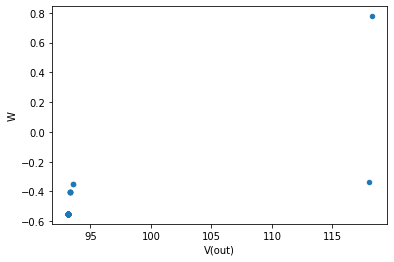

In [24]:
df.plot(x='V(out)', y='W', kind='scatter')

In [25]:
df[(df["V(out)"]>0.58)&(df["V(out)"]<0.61)].sort_values('V(out)')

,L,L_str,R,R_str,V(out),W
